# Installing requirements

In [1]:
dataset_path = 'dataset.json'
batch_dataset_path = 'batch_dataset.json'

In [2]:
!pip install huggingface_hub
!pip install datasets
!pip install scikit-learn
!pip install matplotlib

from pathlib import Path
from huggingface_hub import notebook_login
import datasets
import warnings
from tqdm import tqdm, TqdmWarning
warnings.filterwarnings('ignore', category = TqdmWarning)
import numpy as np
import pandas as pd
import json
from sklearn.feature_extraction.text import CountVectorizer
import random
import matplotlib.pyplot as plt
import matplotlib.colors as colors

You should consider upgrading via the 'C:\Users\Homeworkace\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Homeworkace\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Homeworkace\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Homeworkace\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


# Download the dataset

In [3]:
if Path(dataset_path).exists() :
    dataset = pd.read_json(dataset_path)
else :
    notebook_login()
    hugging_face_dataset = datasets.load_dataset('lmsys/chatbot_arena_conversations')
    dataset = hugging_face_dataset['train'].to_pandas()
    dataset.to_json(dataset_path)

In [4]:
dataset[dataset['turn'] > 3][:1]

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,turn,anony,language,tstamp,openai_moderation,toxic_chat_tag
33,8120899314f74641b09c2aa114d4d253,alpaca-13b,vicuna-13b,model_b,arena_user_316,[{'content': 'Salut ! Comment ça va ce matin ?...,[{'content': 'Salut ! Comment ça va ce matin ?...,6,True,French,1.682354e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil..."


# Create text-author pairs

In [5]:
# Initialize an empty list for processed data
text_author_pairs = []

# Iterate through each row of the DataFrame
for _, row in dataset.iterrows():
    # Process conversation_a (assistant role)
    for message in row["conversation_a"]:
        if message["role"] == "assistant":
            text_author_pairs.append({
                "text": message["content"],
                "author": row["model_a"]
            })

    # Process conversation_b (assistant role)
    for message in row["conversation_b"]:
        if message["role"] == "assistant":
            text_author_pairs.append({
                "text": message["content"],
                "author": row["model_b"]
            })

    # Process user messages (common across both conversations)
    for message in row["conversation_a"]:  # Check only `conversation_a` since user messages are identical
        if message["role"] == "user":
            text_author_pairs.append({
                "text": message["content"],
                "author": "human"
            })

# Create token count vectors for each text

In [6]:
# Extract texts and their authors
texts = [entry['text'] for entry in text_author_pairs]
authors = [entry['author'] for entry in text_author_pairs]

# Vectorize the paragraphs
vectoriser = CountVectorizer()
text_vectors = vectoriser.fit_transform(texts)  # Each row is a text

# Allocate quotas for each batch.
batch_count = {} 
for author in list(set(authors)) :
    # Find out how many batches of 200 texts are needed.
    number_of_batches = round(authors.count(author) / 200)
    for i in range(number_of_batches) :
        # Distribute the remainder/shortfall evenly.
        batch_count[str(i) + '_' + author] = np.floor((i + 1) * authors.count(author) / number_of_batches)
        for j in range(i) :
            # Subtract the count of previous batches.
            batch_count[str(i) + '_' + author] -= batch_count[str(j) + '_' + author]
        
print('Populating batches...')
batch_vectors = {}
batch_quota = batch_count.copy()
for i, author in enumerate(tqdm(authors)):
    batch_to_insert = [name for name in batch_quota if author in name and batch_quota[name] > 0][0]
    if batch_to_insert in batch_vectors:
        # The resulting vectors represent the number of times each token appears in that author's entire corpus.
        batch_vectors[batch_to_insert] += text_vectors[i].toarray()
    else:
        # Add this new batch to the list.
        batch_vectors[batch_to_insert] = text_vectors[i].toarray()
    batch_quota[batch_to_insert] -= 1

# Convert to a dataframe
print('Converting into DataFrame...')
batch_dataset = pd.DataFrame({name: vector.flatten() for name, vector in tqdm(batch_vectors.items())}, index = vectoriser.get_feature_names_out())

batch_dataset

Populating batches...


100%|████████████████████████████████████████████████████████████████████████| 117948/117948 [01:19<00:00, 1483.58it/s]


Converting into DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 591/591 [00:00<00:00, 2204.73it/s]


,0_chatglm-6b,0_koala-13b,0_human,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_human,...,190_human,191_human,192_human,6_wizardlm-13b,193_human,6_gpt4all-13b-snoozy,5_guanaco-33b,194_human,195_human,196_human
00,0,0,0,0,8,3,1,0,1,3,...,0,0,0,3,0,0,0,0,0,2
000,3,1,0,4,0,2,4,0,0,0,...,0,0,3,6,0,3,0,7,2,0
0000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000000,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ｔｏ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ｗｅｅｋｓ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
𝘀𝗶𝗺𝗽𝗹𝗲,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Group texts by author

In [7]:
# Find the average text length of each author. 
batch_average_length = {name: np.sum(vector) / batch_count[name] for name, vector in batch_vectors.items()}

# Normalise the length of each corpus.
print('Normalising...')
for name in tqdm(batch_vectors) :
    batch_dataset[name] /= np.sum(batch_vectors[name])
    
# Since it has been lost, add the average text length as a separate feature.
batch_dataset = pd.concat([batch_dataset, pd.DataFrame(batch_average_length, index = [' length'])])

batch_dataset

Normalising...


100%|████████████████████████████████████████████████████████████████████████████████| 591/591 [01:03<00:00,  9.25it/s]


,0_chatglm-6b,0_koala-13b,0_human,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_human,...,190_human,191_human,192_human,6_wizardlm-13b,193_human,6_gpt4all-13b-snoozy,5_guanaco-33b,194_human,195_human,196_human
00,0.000000,0.000000,0.000000,0.000000,0.000926,0.000135,0.000083,0.000000,0.000095,0.000755,...,0.00,0.000,0.000000,0.000124,0.000,0.000000,0.000000,0.000000,0.000000,0.000241
000,0.000095,0.000041,0.000000,0.000201,0.000000,0.000090,0.000331,0.000000,0.000000,0.000000,...,0.00,0.000,0.000619,0.000248,0.000,0.000157,0.000000,0.000939,0.000454,0.000000
0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
000000,0.000000,0.000082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ｗｅｅｋｓ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
𝘀𝗶𝗺𝗽𝗹𝗲,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻𝘀,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
batch_dataset.to_json(batch_dataset_path)

# Custom holdout

In [9]:
def holdout(df, authors, seed) :
    random.seed(seed)
    
    holdout_list = []
    for author in authors :
        batch = df[random.choice([batch for batch in df.columns if author in batch])].copy()
        holdout_list.append(batch)

    holdout_df = pd.concat(holdout_list, axis = 1)
    training_df = df.drop(columns = holdout_df.columns).copy()
    return training_df, holdout_df

# Use the function for this seed 0 run.
training_dataset, holdout_dataset = holdout(batch_dataset, list(set(authors)), 0)
training_dataset

,0_chatglm-6b,0_koala-13b,0_human,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_human,...,190_human,191_human,192_human,6_wizardlm-13b,193_human,6_gpt4all-13b-snoozy,5_guanaco-33b,194_human,195_human,196_human
00,0.000000,0.000000,0.000000,0.000000,0.000926,0.000135,0.000083,0.000000,0.000095,0.000755,...,0.00,0.000,0.000000,0.000124,0.000,0.000000,0.000000,0.000000,0.000000,0.000241
000,0.000095,0.000041,0.000000,0.000201,0.000000,0.000090,0.000331,0.000000,0.000000,0.000000,...,0.00,0.000,0.000619,0.000248,0.000,0.000157,0.000000,0.000939,0.000454,0.000000
0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
000000,0.000000,0.000082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ｗｅｅｋｓ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
𝘀𝗶𝗺𝗽𝗹𝗲,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻𝘀,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000


# Feature selection

In [10]:
def common_tokens(dataset, holdout_dataset) :
    human_dataset = dataset[[name for name in dataset.columns if 'human' in name]].copy()
    llm_dataset = dataset[[name for name in dataset.columns if not 'human' in name]].copy()
    dataset = pd.merge(llm_dataset[llm_dataset.ne(0).sum(axis=1) == llm_dataset.shape[1]], human_dataset, left_index=True, right_index=True, validate='1:1')
    holdout_dataset = holdout_dataset.loc[dataset.index].copy()
    return dataset, holdout_dataset

training_dataset, holdout_dataset = common_tokens(training_dataset, holdout_dataset)
training_dataset

,0_chatglm-6b,0_koala-13b,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_vicuna-13b,1_koala-13b,...,187_human,188_human,189_human,190_human,191_human,192_human,193_human,194_human,195_human,196_human
10,0.000698,0.000945,0.000705,0.000463,0.000630,0.000994,0.000687,0.001040,0.000472,0.000806,...,0.001238,0.000262,0.001459,0.001037,0.001772,0.001856,0.002592,0.001610,0.000227,0.000481
about,0.001776,0.001068,0.001309,0.000810,0.002116,0.001160,0.003070,0.002459,0.001769,0.002110,...,0.001856,0.003148,0.005209,0.005965,0.002658,0.005568,0.003672,0.004428,0.002496,0.001443
after,0.000317,0.000205,0.000554,0.000231,0.000180,0.000580,0.000404,0.000095,0.000708,0.000345,...,0.000619,0.000262,0.000417,0.000259,0.001624,0.000825,0.000864,0.005233,0.000227,0.000601
all,0.001237,0.001068,0.001107,0.001620,0.000856,0.000994,0.002101,0.001797,0.000708,0.001189,...,0.003249,0.001574,0.001459,0.002075,0.002805,0.002475,0.002592,0.002147,0.001815,0.000241
also,0.003075,0.002998,0.002718,0.004165,0.003062,0.002486,0.002747,0.002838,0.002713,0.003108,...,0.000309,0.001049,0.000417,0.000259,0.000886,0.000412,0.001080,0.001342,0.000908,0.000241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
world,0.000919,0.001027,0.000856,0.001620,0.001396,0.000994,0.001656,0.002459,0.001455,0.001650,...,0.000464,0.000787,0.000417,0.000259,0.000000,0.000825,0.001944,0.000000,0.000681,0.000361
would,0.000476,0.001930,0.001057,0.003008,0.001891,0.001740,0.002141,0.001419,0.001455,0.001919,...,0.001238,0.001049,0.003751,0.003112,0.002362,0.003300,0.001080,0.001476,0.002042,0.000722
you,0.009480,0.010103,0.012080,0.010066,0.008240,0.010108,0.013492,0.013432,0.008965,0.009247,...,0.008199,0.017576,0.012294,0.013485,0.005758,0.016498,0.013610,0.013149,0.010211,0.003007
your,0.003234,0.004271,0.006845,0.003587,0.004233,0.002900,0.004039,0.003689,0.003146,0.005986,...,0.001547,0.002099,0.003126,0.002334,0.002658,0.003300,0.006697,0.002549,0.003177,0.000962


# Centring

In [11]:
def centre(dataset, holdout_dataset) :
    features_mean = pd.Series({feature: np.mean(dataset.loc[feature]) for feature in dataset.index})
    for batch in dataset.columns :
        dataset[batch] -= features_mean
    for batch in holdout_dataset.columns :
        holdout_dataset[batch] -= features_mean
    return dataset, holdout_dataset
    
training_dataset, holdout_dataset = centre(training_dataset, holdout_dataset)
training_dataset[training_dataset.index == ' length']

,0_chatglm-6b,0_koala-13b,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_vicuna-13b,1_koala-13b,...,187_human,188_human,189_human,190_human,191_human,192_human,193_human,194_human,195_human,196_human
length,76.096582,39.34912,17.443316,-38.963719,29.207135,-20.179385,39.554859,-29.270252,44.75912,47.91412,...,-49.913468,-63.33588,-58.280302,-63.11588,-48.53088,-58.029046,-59.25088,-44.943619,-60.36088,-40.82588


# Standardisation

In [12]:
def standardise(dataset, holdout_dataset) :
    features_std = pd.Series({feature: np.std(dataset.loc[feature]) for feature in dataset.index})
    for batch in dataset.columns :
        dataset[batch] /= features_std
    for batch in holdout_dataset.columns :
        holdout_dataset[batch] /= features_std
    return dataset, holdout_dataset
    
training_dataset, holdout_dataset = standardise(training_dataset, holdout_dataset)
training_dataset[training_dataset.index == ' length']

,0_chatglm-6b,0_koala-13b,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_vicuna-13b,1_koala-13b,...,187_human,188_human,189_human,190_human,191_human,192_human,193_human,194_human,195_human,196_human
length,1.592515,0.823481,0.365046,-0.815415,0.611234,-0.422305,0.827786,-0.612555,0.936699,1.002725,...,-1.044567,-1.325465,-1.219664,-1.320861,-1.015632,-1.214406,-1.239976,-0.94056,-1.263205,-0.854386


C:\Users\Homeworkace\AppData\Local\Temp\ipykernel_19348\1364267143.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  feature_graph_figure.show()


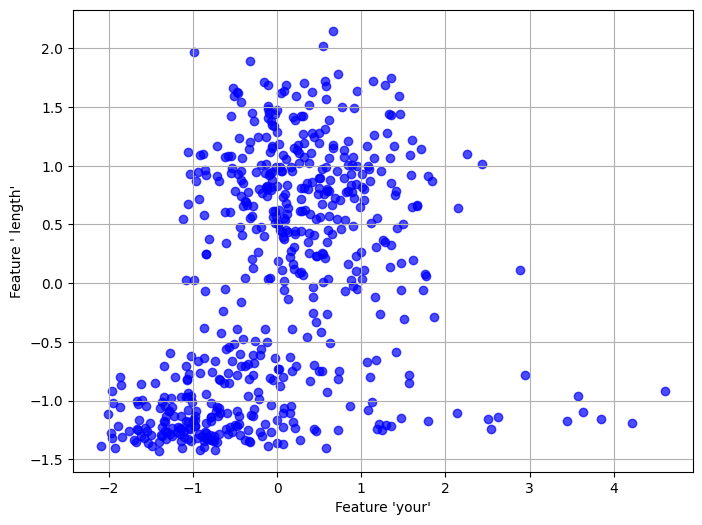

In [13]:
# Extracting the two features
x_token = training_dataset.index[-2]
y_token = training_dataset.index[-1]

# Creating the scatter plot
feature_graph_figure = plt.figure(figsize=(8, 6))
feature_graph = feature_graph_figure.subplots()
feature_graph.scatter(training_dataset.loc[x_token], training_dataset.loc[y_token], color='blue', alpha=0.7)
feature_graph.set_xlabel("Feature '" + x_token + "'")
feature_graph.set_ylabel("Feature '" + y_token + "'")
feature_graph.grid(True)
feature_graph_figure.show()

In [14]:
def power_iteration(A, num_iter=1000, tol=1e-6):
    """
    Power Iteration to compute the largest eigenvector of matrix A.
    Args:
        A (np.ndarray): Input symmetric matrix.
        num_iter (int): Number of iterations.
        tol (float): Tolerance for convergence.

    Returns:
        eigenvector (np.ndarray): Approximation of the largest eigenvector.
        eigenvalue (float): Corresponding eigenvalue.
    """
    b = np.random.rand(A.shape[1])  # Random initial vector
    b = b / np.linalg.norm(b)

    error_meter = tqdm(position = 0, total=6, bar_format='{bar} | {postfix}')
    for i in range(num_iter):
        b_next = A @ b  # Matrix-vector multiplication
        b_next = b_next / np.linalg.norm(b_next)  # Normalize
        
        # Check for convergence
        error = np.linalg.norm(b_next - b)
        b = b_next
        error_meter.update(min(-np.log10(error), error_meter.total) - error_meter.n)
        error_meter.set_postfix_str('{:.2E}'.format(error) + ' of error after ' + str(i + 1) + ' iterations...')
        if error < tol:
            error_meter.close()
            break

    eigenvalue = b.T @ A @ b  # Rayleigh quotient for eigenvalue
    return b, eigenvalue

In [15]:
def pca_power_iteration(data, num_components, num_iter=2000):
    """
    PCA using Power Iteration to compute the principal components.
    Args:
        data (np.ndarray): Input data matrix (rows are samples, columns are features).
        num_components (int): Number of principal components to compute.
        num_iter (int): Number of iterations for power iteration.

    Returns:
        components (list): List of principal components (eigenvectors).
        explained_variance (list): List of corresponding eigenvalues.
    """
    covariance_matrix = np.cov(data, rowvar=True, ddof = 0)
    
    # Compute covariance matrix manually
    n = data.shape[1]  # Number of samples (columns in your case)
    covariance_matrix = (data @ data.T) / n

    components = []
    explained_variance = []

    for i in range(num_components):
        # Step 2: Compute the largest eigenvector using power iteration
        print('Computing PC' + str(i + 1) + '...')
        eigenvector, eigenvalue = power_iteration(covariance_matrix, num_iter=num_iter)
        components.append(eigenvector)
        explained_variance.append(eigenvalue)
        
        # Step 3: Deflate the covariance matrix
        covariance_matrix -= eigenvalue * np.outer(eigenvector, eigenvector)
        if np.linalg.norm(covariance_matrix, ord='fro') < 1e-10 :
            print('Stopped as all variance has been extracted after computing ' + str(i + 1) + ' PCs.')
            break
        
    return components, explained_variance

In [16]:
components, explained_variance = pca_power_iteration(training_dataset, num_components=50)

Computing PC1...


██████████████████████████████████████████████████████████████████████████ | , 4.60E-07 of error after 14 iterations...


Computing PC2...


██████████████████████████████████████████████████████████████████████████ | , 7.59E-07 of error after 42 iterations...


Computing PC3...


██████████████████████████████████████████████████████████████████████████ | , 7.51E-07 of error after 33 iterations...


Computing PC4...


█████████████████████████████████████████████████████████████████████████ | , 9.78E-07 of error after 183 iterations...


Computing PC5...


█████████████████████████████████████████████████████████████████████████ | , 9.75E-07 of error after 222 iterations...


Computing PC6...


█████████████████████████████████████████████████████████████████████████ | , 9.29E-07 of error after 125 iterations...


Computing PC7...


█████████████████████████████████████████████████████████████████████████ | , 9.92E-07 of error after 299 iterations...


Computing PC8...


█████████████████████████████████████████████████████████████████████████ | , 9.67E-07 of error after 161 iterations...


Computing PC9...


█████████████████████████████████████████████████████████████████████████ | , 9.81E-07 of error after 218 iterations...


Computing PC10...


█████████████████████████████████████████████████████████████████████████ | , 9.77E-07 of error after 248 iterations...


Computing PC11...


██████████████████████████████████████████████████████████████████████████ | , 8.78E-07 of error after 83 iterations...


Computing PC12...


█████████████████████████████████████████████████████████████████████████ | , 9.74E-07 of error after 313 iterations...


Computing PC13...


█████████████████████████████████████████████████████████████████████████ | , 9.95E-07 of error after 336 iterations...


Computing PC14...


█████████████████████████████████████████████████████████████████████████ | , 9.97E-07 of error after 456 iterations...


Computing PC15...


██████████████████████████████████████████                                | , 3.45E-04 of error after 196 iterations...IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

█████████████████████████████████████████████████████████████████████████ | , 9.91E-07 of error after 639 iterations...


Computing PC17...


█████████████████████████████████████████████████████████████████████████ | , 9.84E-07 of error after 210 iterations...


Computing PC18...


█████████████████████████████████████████████████████████████████████████ | , 9.98E-07 of error after 754 iterations...


Computing PC19...


█████████████████████████████████████████████████████████████████████████ | , 9.73E-07 of error after 268 iterations...


Computing PC20...


█████████████████████████████████████████████████████████████████████████ | , 9.90E-07 of error after 457 iterations...


Computing PC21...


█████████████████████████████████████████████████████████████████████████ | , 1.00E-06 of error after 217 iterations...


Computing PC22...


█████████████████████████████████████████████████████████████████████████ | , 9.67E-07 of error after 254 iterations...


Computing PC23...


█████████████████████████████████████████████████████████████             | , 9.53E-06 of error after 760 iterations...IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

████████████████████████████████████████████████████████████████████████ | , 9.96E-07 of error after 1111 iterations...


Computing PC25...


█████████████████████████████████████████████████████████████████████████ | , 9.94E-07 of error after 884 iterations...


Computing PC26...


█████████████████████████████████████████████████████████████████████████ | , 9.89E-07 of error after 352 iterations...


Computing PC27...


█████████████████████████████████████████████████████████████████████████ | , 9.98E-07 of error after 279 iterations...


Computing PC28...


█████████████████████████████████████████████████████████████████████████ | , 9.78E-07 of error after 461 iterations...


Computing PC29...


█████████████████████████████████████████████████████████████████████████ | , 9.95E-07 of error after 277 iterations...


Computing PC30...


███████████████████████████████████████████████████████▊                  | , 2.59E-05 of error after 357 iterations...IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

████████████████████████████████████████████▊                            | , 1.82E-04 of error after 2000 iterations...


Computing PC31...


█████████████████████████████████████████████████████████████████████████ | , 9.89E-07 of error after 489 iterations...


Computing PC32...


█████████████████████████████████████████████████████████████████████████ | , 9.86E-07 of error after 544 iterations...


Computing PC33...


█████████████████████████████████████████████████████████████████████████ | , 9.72E-07 of error after 253 iterations...


Computing PC34...


█████████████████████████████████████████████████████████████████████████ | , 9.93E-07 of error after 809 iterations...


Computing PC35...


█████████████████████████████████████████████████████▏                    | , 4.20E-05 of error after 241 iterations...IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

█████████████████████████████████████████████████████████████████████████ | , 9.94E-07 of error after 571 iterations...


Computing PC38...


█████████████████████████████████████████████████████████████████████████ | , 9.98E-07 of error after 326 iterations...


Computing PC39...


█████████████████████████████████████████████████████████▌               | , 1.61E-05 of error after 2000 iterations...


Computing PC40...


██████████████████████████████████████████████████████▉                   | , 3.05E-05 of error after 240 iterations...IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

████████████████████████████████████████████████████████████████████████ | , 9.97E-07 of error after 1200 iterations...


Computing PC42...


█████████████████████████████████████████████████████████████████████████ | , 9.90E-07 of error after 256 iterations...


Computing PC43...


█████████████████████████████████████████████████████████████████████████ | , 9.84E-07 of error after 464 iterations...


Computing PC44...


█████████████████████████████████████████████████████████████████████████ | , 1.00E-06 of error after 299 iterations...


Computing PC45...


█████████████████████████████████████████████████████████████████████████ | , 9.93E-07 of error after 751 iterations...


Computing PC46...


█████████████████████████████████████████████████████████████████████████ | , 9.98E-07 of error after 414 iterations...


Computing PC47...


████████████████████████████████▋                                         | , 2.08E-03 of error after 362 iterations...IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

█████████████████████████████████████████████████████████████████████████ | , 9.96E-07 of error after 848 iterations...


Computing PC49...


█████████████████████████████████████████████████████████████████████████ | , 9.86E-07 of error after 527 iterations...


Computing PC50...


█████████████████████████████████████████████████████████▋               | , 1.57E-05 of error after 1923 iterations...IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



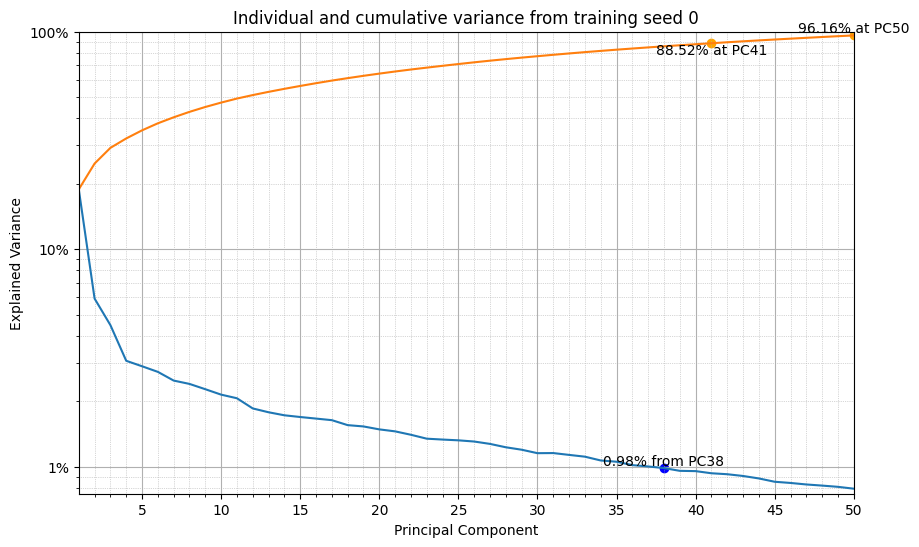

In [17]:
plt.figure(figsize=(10, 6))
plt.xticks(range(0, 51, 5))
plt.xlim(1, 50)
plt.yscale('log')
plt.ylim(0.75, 100)
plt.yticks([1, 10, 100], labels=["1%", "10%", "100%"])
plt.plot(range(1, 51), explained_variance)
plt.plot(range(1, 51), [np.sum(explained_variance[:i]) for i in range(1, 51)])

# Points of interest
plt.scatter(41, np.sum(explained_variance[:41]), color='orange')
plt.annotate('{0:.2f}'.format(np.sum(explained_variance[:41])) + '% at PC41' , (41, np.sum(explained_variance[:41])), ha = 'center', va = 'top')
plt.scatter(50, np.sum(explained_variance), color='orange')
plt.annotate('{0:.2f}'.format(np.sum(explained_variance)) + '% at PC50' , (50, np.sum(explained_variance)), ha = 'center', va = 'bottom')
plt.scatter(38, explained_variance[37], color='blue')
plt.annotate('{0:.2f}'.format(explained_variance[37]) + '% from PC38' , (38, explained_variance[37]), ha = 'center', va = 'bottom')

plt.title('Individual and cumulative variance from training seed 0')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.minorticks_on()
#plt.grid(axis = 'x', which = 'minor')
plt.grid(which='minor', axis='x', linestyle=':', linewidth=0.5)  # Minor grid lines on X-axis
plt.grid(which='minor', axis='y', linestyle=':', linewidth=0.5)  # Minor grid lines on X-axis
plt.show()

In [18]:
def transform_to_pc(batch, components) :
    pc_space_batch = []
    for component in components :
        pc_space_batch.append(np.dot(batch, component))
        
    return pc_space_batch

[-6.06642814213338, 4.548030207284515, -2.9995706202598833, -3.383327020230681, 0.1286178996984609, 0.8964928119099822, 1.8910814096326185, 2.7046023380190536, -1.2267746251312595, 1.057641439020877, 2.5680760000051794, -3.0564178060674085, 0.821477767143772, 0.8594478738886878, 1.1670067036287037, 0.6280624786492126, -2.5147333445805993, 5.438925611725645, -0.9453137192227381, -3.011866144933846, 2.971726031569107, -0.20698223627862722, 5.123460568937994, -2.2655690981192196, -2.044376599338091, 2.726586023379384, -2.1239169681896115, 3.1599900162019203, 0.6240890611197235, -0.4102773986225815, -0.956446672186088, 0.9794338397993707, -0.7059887165043632, -2.497052826418747, 1.573321351773639, 0.4587076901167579, 1.4153782955055476, -0.7836354934430737, 2.7729669577859726, -0.7773216675464982, 0.43144479841450323, -2.163286380431376, -1.2053957774661903, -0.08235114860087009, 1.7550959179094876, -1.0544228734254277, 0.9864461448180096, -0.11597616866356056, 0.45048224699414907, 1.23516

TypeError: cannot unpack non-iterable numpy.float64 object

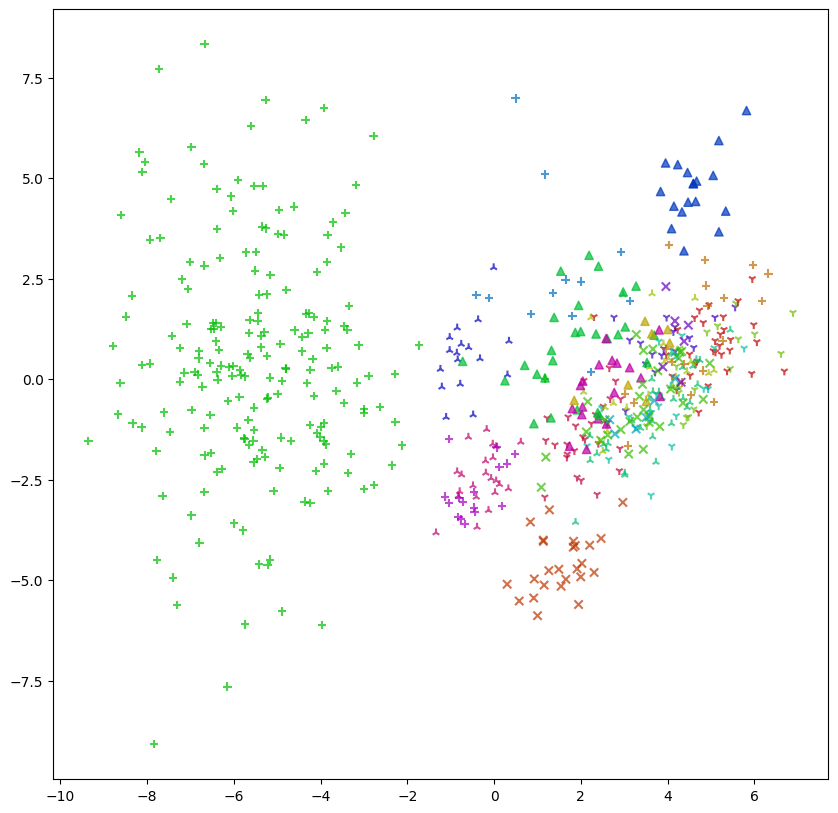

In [53]:
# Define a colour and marker shape for each author using a non-integer index; the integer part determines the shape and the decimal part the colour.
marker_list = {author: i * 5 / len(set(authors)) for i, author in enumerate(list(set(authors)))}

# Plot all training and holdout batches, but in five groups, with a shape for each.
labels = [batch.split('_')[1] for batch in training_dataset] + [batch.split('_')[1] for batch in holdout_dataset]
coords = [transform_to_pc(training_dataset[batch], components) for batch in training_dataset] + [transform_to_pc(holdout_dataset[batch], components) for batch in holdout_dataset]
coord_groups = [[] for i in range(5)]
for i in range(len(labels)) :
    coord_groups[int(marker_list[labels[i]])].append(i)

# Creating the scatter plot
feature_graph_figure = plt.figure(figsize=(10, 10))
feature_graph = feature_graph_figure.subplots()
for group, marker in enumerate(['1', '2', '^', '+', 'x']) :
    feature_graph.scatter([coords[i][0] for i in coord_groups[group]], [coords[i][1] for i in coord_groups[group]], color=[colors.hsv_to_rgb((marker_list[labels[i]] % 1, 1, 0.75)) for i in coord_groups[group]], alpha=0.7, marker = marker)
[print(coords[i][) for i, name in enumerate(training_dataset.columns) if name.split('_')[1] == 'human']
for author in list(set(authors)):
    feature_graph.annotate(author, np.mean([coords[i][:2] for i, name in enumerate(training_dataset.columns) if name.split('_')[1] == author]))
feature_graph.set_xlabel("PC1")
feature_graph.set_ylabel("PC2")
feature_graph.grid(True)
feature_graph_figure.show()

In [49]:
ranking = np.argsort(components[0])
dimensions = training_dataset.index[ranking]
weights = components[0][ranking]
for i in range(len(dimensions)) :
    print(dimensions[i] + ' ' + str(weights[i]))

what -0.1905247721808767
me -0.1834313652701672
how -0.17861783412610507
do -0.1581392429538864
about -0.13560125275450358
my -0.11889669529412544
only -0.10718397431437518
should -0.10523817885181569
an -0.08910052120287226
who -0.07708995686965006
one -0.07196520366619932
at -0.07027377155452309
name -0.06605334465217398
no -0.06491440553167645
all -0.06297624057782959
like -0.06110388520988592
know -0.059860890799020135
after -0.05963557292460961
when -0.059151600717422786
10 -0.05408765862574093
first -0.05389933616505384
many -0.05336605984055466
best -0.05124092091614592
you -0.051136077040511714
would -0.04974577981640618
two -0.04936548865874345
out -0.048216575405031305
in -0.0468929203243985
where -0.04596482400624676
don -0.044361889955128894
from -0.04372448294500676
just -0.04228934088809564
get -0.03898698272088168
same -0.03771550664857866
then -0.03731506807540458
without -0.036759399401447145
each -0.036341151379705706
if -0.033901720604801774
most -0.03164852612256911

# k-Nearest Neighbours

In [131]:
def k_nearest_neighbours(X_train, y_train, X_test, k = 3):
    """
    Predict labels for the test dataset.
    """
    predictions = []

    for test_point in X_test:
        # Compute distances to all training points
        distances = [np.linalg.norm(train_point - test_point) for train_point in X_train]

        k_indices = np.argsort(distances)[:k] # Find indices of k nearest neighbors
        k_labels = y_train[k_indices] # Retrieve the labels of the k nearest neighbors
        unique_labels, counts = np.unique(k_labels, return_counts=True) # Determine the most common label (majority voting)
        while np.count_nonzero(counts == np.max(counts)) != 1 : # In the event of tiebreaks, reduce k. At k = 1 a winner is guaranteed.
            k -= 1
            unique_labels, counts = np.unique(y_train[np.argsort(distances)[:k]], return_counts=True)
        
        predictions.append(unique_labels[np.argmax(counts)])
    
    return np.array(predictions)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['alpaca-13b' 'palm-2' 'stablelm-tuned-alpha-7b' 'gpt-3.5-turbo'
 'fastchat-t5-3b' 'dolly-v2-12b' 'vicuna-7b' 'chatglm-6b'
 'RWKV-4-Raven-14B' 'koala-13b' 'dolly-v2-12b' 'human' 'gpt-4'
 'stablelm-tuned-alpha-7b' 'mpt-7b-chat' 'RWKV-4-Raven-14B' 'koala-13b'
 'claude-instant-v1' 'koala-13b' 'vicuna-7b' 'claude-instant-v1']
11 out of 21


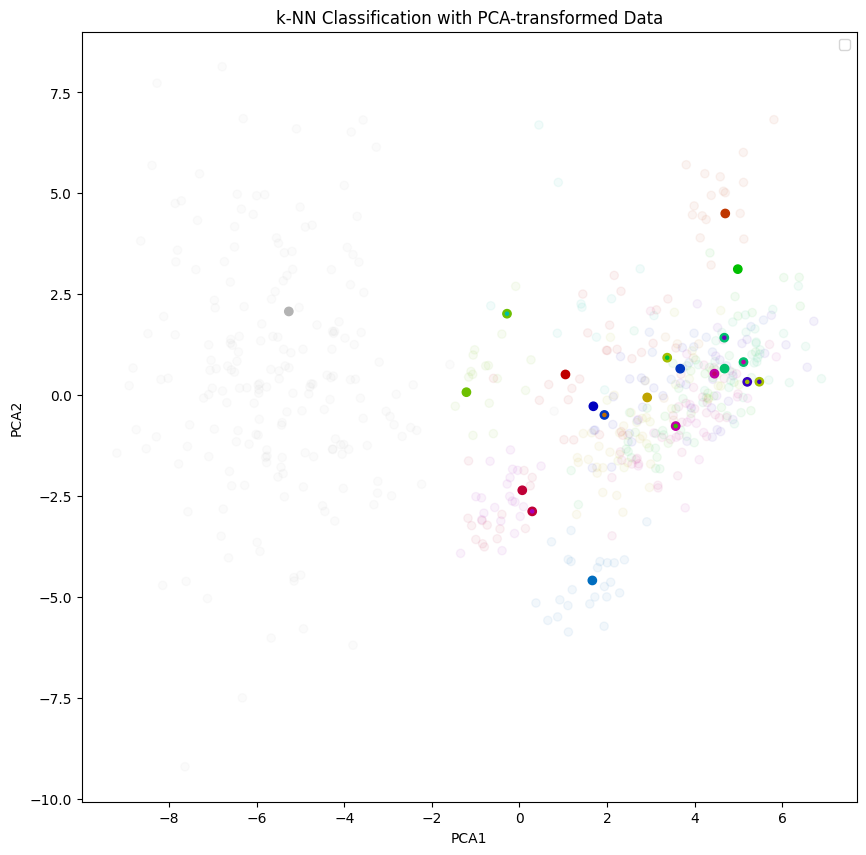

In [139]:
training_batches = np.array([transform_to_pc(training_dataset[batch], components[:10]) for batch in training_dataset])
training_labels = np.array([batch.split('_')[1] for batch in training_dataset])
testing_batches = np.array([transform_to_pc(holdout_dataset[batch], components[:10]) for batch in holdout_dataset])
testing_labels = np.array([batch.split('_')[1] for batch in holdout_dataset])

predictions = k_nearest_neighbours(training_batches, training_labels, testing_batches, 5)
print(predictions)
print(str((predictions == testing_labels).sum()) + ' out of ' + str(len(testing_labels)))

# Visualization example:
plt.figure(figsize=(10, 10))
plt.scatter([batch[0] for batch in training_batches], [batch[1] for batch in training_batches], c=[marker_list[batch.split('_')[1]] for batch in training_dataset], alpha=0.05)
plt.scatter([batch[0] for batch in testing_batches], [batch[1] for batch in testing_batches], c=[marker_list[batch] for batch in predictions])
plt.scatter([batch[0] for batch in testing_batches], [batch[1] for batch in testing_batches], c=[marker_list[batch] for batch in testing_labels], s = 5)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.title('k-NN Classification with PCA-transformed Data')
plt.show()

In [153]:
def test_suite() :
    results = {}  # Dictionary to store accuracy results for each (d, k) pair

    # turn all data processing into functions
    
    # for d in range(len(components)) :
    for d in range(1, 6) :
        training_batches = np.array([transform_to_pc(training_dataset[batch], components[:d]) for batch in training_dataset])
        training_labels = np.array([batch.split('_')[1] for batch in training_dataset])
        testing_batches = np.array([transform_to_pc(holdout_dataset[batch], components[:d]) for batch in holdout_dataset])
        testing_labels = np.array([batch.split('_')[1] for batch in holdout_dataset])
        
        for k in range(1, 25) :
            predictions = k_nearest_neighbours(training_batches, training_labels, testing_batches, k)
            
            # Calculate accuracy
            correct = np.sum(predictions == testing_labels)
            accuracy = correct / len(testing_labels)  # Proportion of correct predictions
            
            # Store results
            results[(d, k)] = accuracy

    # Some way of displaying accuracy over various d and k
    plt.figure(figsize=(10, 6))
    for k in range(1, 25):
        accuracies = [results[(d, k)] for d in range(1, 6)]
        plt.plot(range(1, 6), accuracies, label=f'k={k}')
    
    plt.xlabel('Number of Principal Components (d)')
    plt.ylabel('Accuracy')
    plt.title('k-NN Accuracy vs Number of Principal Components')
    plt.legend()
    plt.grid(True)
    plt.show()

    return results

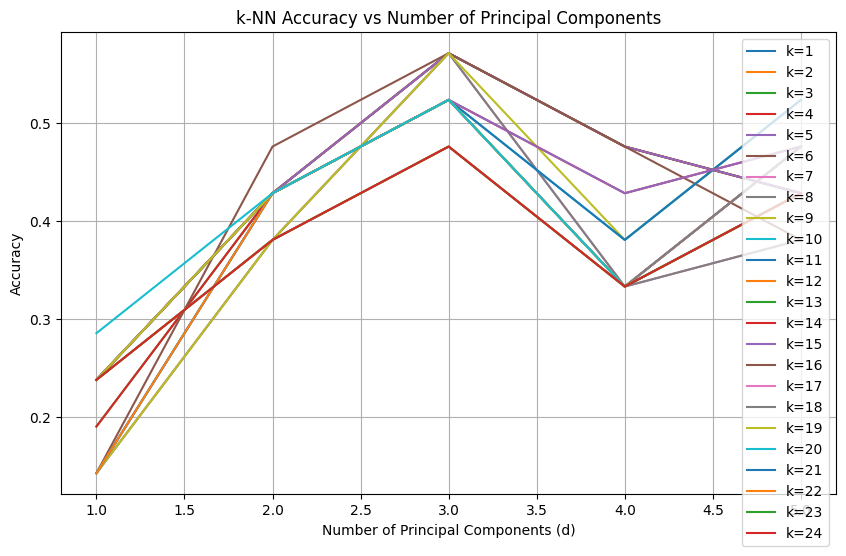

In [155]:
_ = test_suite()